
**XLM-RoBERTa for Filipino News Category ClassificationBalitaNLP Dataset - 81 Categories reduced through preprocessing**

This dataset was originally intended for text generation but is utilized for classification in this study

This notebook demonstrates:
1. Data loading and preprocessing (category merging)
2. Exploratory Data Analysis (word-category connections)
3. XLM-RoBERTa fine-tuning
4. Model evaluation

Authors: Dave Arius Badillo, Allen Cabansag, Hendrix Leonard Maligaya
Date: October 2025


In [ ]:
"""
imports_and_stopwords.py

This block imports all required libraries, detects CUDA, and creates the combined stopword set
for Filipino (Tagalog) and English using stopwordsiso.

Main content:
  - filipino_stopwords: set of Tagalog stopwords.
  - english_stopwords: set of English stopwords.
  - combined_stopwords: union of filipino_stopwords and english_stopwords.
"""

#IMPORTS
!pip install stopwordsiso
print("=" * 80)
print("STEP 1: IMPORTING LIBRARIES")
print("=" * 80)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

import stopwordsiso as stopwords
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    XLMRobertaTokenizer, 
    XLMRobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

filipino_stopwords = stopwords.stopwords("tl")  # Tagalog
english_stopwords = stopwords.stopwords("en")   # English
combined_stopwords = filipino_stopwords.union(english_stopwords)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.6 MB/s eta 0:00:00
STEP 1: IMPORTING LIBRARIES


2025-10-19 21:48:33.945140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760910514.372370      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760910514.492664      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ GPU: Tesla T4


In [ ]:
"""
Loads JSON dataset files and prepares a combined text field used throughout the pipeline.
Handles variations in JSON format (newline-delimited vs standard).

Main functions:
- load_and_clean_data(file_path):
    Loads a dataset from JSON, converts 'body' lists
    to a single string, drops unused columns if present, fills missing title/body with empty strings,
    concatenates title + body into 'combined_text', and standardizes the 'category' column.
    Returns a pandas.DataFrame ready for downstream processing.
"""


TRAIN_PATH = '/kaggle/input/balitanlp/train.json'
VALIDATION_PATH = '/kaggle/input/balitanlp/validation.json'
TEST_PATH = '/kaggle/input/balitanlp/test.json'

def load_and_clean_data(file_path):
    try:
        df = pd.read_json(file_path, lines=True)
    except ValueError:
        df = pd.read_json(file_path)
    #Process body text
    df['full_text'] = df['body'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
    #Drop unnecessary columns
    df = df.drop(columns=['body', 'url', 'img_url', 'img_path'], errors='ignore')
    #Fill NaN values (fixed FutureWarning)
    df['full_text'] = df['full_text'].fillna('')
    df['title'] = df['title'].fillna('')
    #Combine title and body for better context
    df['combined_text'] = df['title'] + ' ' + df['full_text']
    #Clean category names (strip whitespace
    df['category'] = df['category'].astype(str).str.strip()
    
    return df
train_df = load_and_clean_data(TRAIN_PATH)
print(f"\nTrain samples loaded: {len(train_df):,}")
val_df = load_and_clean_data(VALIDATION_PATH)
print(f"\nValidation samples loaded: {len(val_df):,}")
test_df = load_and_clean_data(TEST_PATH)
print(f"\nTest samples loaded: {len(test_df):,}")

print(f"\nTotal samples: {len(train_df) + len(val_df) + len(test_df):,}")
print()


Train samples loaded: 281,403

Validation samples loaded: 35,175

Test samples loaded: 35,177

Total samples: 351,755



In [ ]:
"""
Defines language-aware keyword lists used to infer/news-redistribute article categories
based on textual content. This block contains a dictionary of keyword lists per category.

Main content:
- CATEGORY_KEYWORDS: dict[str, list[str]]
    A mapping of category names to lists of Tagalog/English keywords. Used by keyword-based
    refinement to detect category-specific signals in article text.
"""

# Define keyword patterns for each category
CATEGORY_KEYWORDS = {
    'crime': [
        # Tagalog crime words
        'pulis', 'arestado', 'suspek', 'krimen', 'nakuha', 'nahuli',
        'robbery', 'theft', 'murder', 'homicide', 'kidnap',
        'droga', 'shabu', 'drugs', 'raid', 'operation',
        'tulak', 'holdup', 'salakay', 'patay', 'napatay',
        'warrant', 'kaso', 'imbestigasyon', 'aksidente',
        'nagsagawa ng operasyon', 'naaresto', 'huli',
        # Police/law enforcement
        'pnp', 'nbi', 'pdea', 'police', 'authorities',
        'hepe', 'chief', 'investigator', 'detektib'
    ],
    
    'metro': [
        # Manila/NCR locations
        'manila', 'quezon city', 'makati', 'pasig', 'taguig',
        'mandaluyong', 'pasay', 'caloocan', 'marikina', 'paranaque',
        'las pinas', 'muntinlupa', 'valenzuela', 'malabon',
        'san juan', 'ncr', 'metro manila', 'kamaynilaan',
        # Urban/traffic issues
        'edsa', 'traffic', 'lrt', 'mrt', 'mmda', 'trapiko',
        'c5', 'commonwealth', 'katipunan', 'espana',
        # Local government
        'mayor', 'city hall', 'barangay', 'brgy',
        'ordinansa', 'city council', 'konseho',
        # Urban issues
        'flooding', 'baha', 'garbage', 'basura',
        'sidewalk', 'bangketa', 'street vendor'
    ],
    
    'bansa': [
        # Government/politics
        'duterte', 'marcos', 'robredo', 'aquino',
        'senate', 'congress', 'senado', 'kongreso',
        'senator', 'congressman', 'representative',
        'presidente', 'vice president', 'pangulo',
        'da', 'dar', 'dbm', 'denr', 'deped', 'dfa',
        'dhsud', 'dict', 'dilg', 'dnd', 'doe', 'dof',
        'doh', 'doj', 'dole', 'dmw', 'dpwh', 'dost', 'dot',
        'dotr', 'dswd', 'dti', 'neda', 'afp', 'bfar', 'bfp',
        'bi', 'bir', 'bjmp', 'blr', 'boc', 'btr', 'bucor', 
        'ched', 'chr', 'coa', 'comelec', 'csc', 'cta', 'dbcc', 
        'gcpp', 'gsis', 'hlurb', 'lra', 'lrta', 'lto', 'mmda', 
        'napolcom', 'nbi', 'nhcp', 'nha', 'nia', 'nlrc', 'nsc', 
        'nso', 'ocd', 'omb', 'pagasa', 'pagcor', 'pcg', 'pdea', 'philhealth', 
        'pnpa', 'prc', 'sec', 'sss', 'tesda','ombudsman','blue ribbon committee',
        'malacañang', 'palace', 'palasyo',
        # Political processes
        'batas', 'bill', 'legislation', 'law', 'republic act',
        'hearing', 'session', 'plenary', 'committee','governor',
        'blue ribbon', 'investigation', 'inquiry','senator',
        'impeachment', 'corruption', 'pork barrel','mayor',
        'election', 'eleksyon', 'comelec', 'voting',
        # National issues
        'budget', 'pondo', 'appropriation',
        'national', 'pangkalahatan', 'bansa',
        'government', 'pamahalaan', 'estado'
    ],
    
    'negosyo': [
        # Business terms
        'negosyo', 'business', 'company', 'kumpanya',
        'ekonomiya', 'economy', 'economic',
        'market', 'stocks', 'shares', 'psei',
        'investor', 'investment', 'profit', 'loss',
        'sales', 'revenue', 'earnings', 'kita',
        'corporate', 'corporation', 'enterprise',
        # Finance
        'bangko', 'bank', 'bsp', 'central bank',
        'loan', 'utang', 'credit', 'interest rate',
        'inflation', 'gdp', 'unemployment',
        # Trade/commerce
        'export', 'import', 'trade', 'kalakalan',
        'tariff', 'customs', 'goods', 'products',
        'manufacturing', 'industry', 'sector',
        # Real estate
        'property', 'real estate', 'condo',
        'development', 'construction', 'pagtatayo'
        # Businessmen
        'lucio tan', 'manny pangilinan', 'lance gokongwei',
        'ramon ang','tony tan caktiong','henry sy',
        'alfredo m. yao','andrew tan','edgar sia',
        'andrew gotianun','edward cojuangco jr','ben ch an',
        'ben chan','vivian que azcona','cecilio kwok pedro'
    ],
    
    'sports': [
        # Sports general
        'laro', 'game', 'match', 'tournament',
        'championship', 'kampeonato', 'finals',
        'team', 'koponan', 'player', 'manlalaro',
        'coach', 'training', 'practice',
        'win', 'lose', 'panalo', 'talo', 'score',
        # Specific sports
        'basketball', 'pba', 'nba', 'fiba',
        'boxing', 'pacquiao', 'manny pacquiao',
        'volleyball', 'football', 'soccer',
        'badminton', 'tennis', 'swimming',
        'athletics', 'marathon', 'olympics',
        # Teams/leagues
        'ginebra', 'san miguel', 'magnolia',
        'meralco', 'tnc', 'blackwater',
        'sea games', 'asian games', 'uaap', 'ncaa'
    ],
    
    'showbiz': [
        # Celebrity indicators
        'artista', 'celebrity', 'star', 'bituin',
        'actor', 'actress', 'aktres',
        'singer', 'mang-aawit', 'performer',
        # Entertainment industry
        'movie', 'pelikula', 'film',
        'teleserye', 'tv show', 'series',
        'concert', 'show', 'performance',
        'abs-cbn', 'gma', 'tv5', 'network',
        # Celebrity life
        'relationship', 'relasyon', 'break-up',
        'wedding', 'kasal', 'engagement',
        'love team', 'couple', 'partner',
        'instagram', 'social media', 'post',
        'debut', 'comeback', 'project',
        # Specific celebrities (add more as needed)
        'vice ganda', 'anne curtis', 'sarah geronimo',
        'kathryn', 'daniel', 'alden', 'maine'
    ],
    
    'probinsiya': [
        # Visayas regions
        'cebu', 'bohol', 'iloilo', 'bacolod',
        'leyte', 'samar', 'dumaguete', 'tacloban',
        # Mindanao regions
        'davao', 'cagayan de oro', 'zamboanga',
        'general santos', 'cotabato', 'iligan',
        'butuan', 'dipolog', 'marawi',
        # Luzon provinces (non-NCR)
        'pampanga', 'bulacan', 'cavite', 'laguna',
        'batangas', 'rizal', 'pangasinan', 'ilocos',
        'baguio', 'bicol', 'albay', 'camarines',
        # Regional terms
        'probinsya', 'province', 'regional',
        'visayas', 'mindanao', 'luzon',
        'municipality', 'munisipyo', 'town'
    ],
    
    'lifestyle': [
        # Health/wellness
        'health', 'kalusugan', 'fitness', 'exercise',
        'diet', 'nutrition', 'wellness', 'mental health',
        'doctor', 'hospital', 'medical', 'gamot',
        # Fashion/beauty
        'fashion', 'beauty', 'makeup', 'cosmetics',
        'style', 'outfit', 'clothing', 'damit',
        'skincare', 'hair', 'salon',
        # Food
        'recipe', 'resipe', 'food', 'pagkain',
        'restaurant', 'cafe', 'dining', 'kainan',
        'cooking', 'pagluluto', 'chef',
        # Travel
        'travel', 'biyahe', 'destination', 'destinasyon',
        'tourist', 'turista', 'vacation', 'bakasyon',
        'beach', 'resort', 'hotel', 'trip',
        # Lifestyle general
        'tips', 'guide', 'how to', 'paano',
        'advice', 'payo', 'home', 'tahanan'
    ],
    
    'pinoyabroad': [
        # OFW terms
        'ofw', 'overseas filipino worker',
        'abroad', 'ibang bansa', 'overseas',
        'dfa', 'owwa', 'poea', 'passport',
        'embassy', 'consulate', 'ambassador',
        # Common destinations
        'dubai', 'saudi', 'riyadh', 'jeddah',
        'hong kong', 'singapore', 'taiwan',
        'japan', 'korea', 'canada', 'usa',
        'italy', 'uk', 'australia', 'new zealand',
        # OFW-related
        'remittance', 'padala', 'deployment',
        'contract', 'kontrata', 'work permit',
        'migrant', 'immigrant', 'expat',
        'filipino community', 'pinoy community'
    ],
    
    'opinyon': [
        # Opinion indicators
        'opinion', 'opinyon', 'editorial',
        'column', 'kolum', 'commentary',
        'viewpoint', 'perspective', 'pananaw',
        # First-person/subjective language
        'sa aking palagay', 'i think', 'i believe',
        'dapat', 'kailangan', 'we should',
        'in my view', 'sa tingin ko',
        # Analysis terms
        'analysis', 'analisis', 'reflection',
        'critique', 'kritika', 'assessment'
    ]
}

In [ ]:
"""
Normalizes and consolidates variant category labels into canonical categories to reduce label noise.

Main functions:
- merge_categories(df):
    Normalizes category strings (lowercase & strip) and applies a mapping from many label variants
    (e.g., 'local news', 'promdi', 'sports bisaya', etc.) to canonical categories such as
    'news', 'probinsiya', 'sports', 'opinyon', 'negosyo', etc. Returns the modified DataFrame.
"""

def merge_categories(df):
    """
    Merge duplicate categories by:
    1. Converting to lowercase
    2. Mapping similar categories together
    """
        
    original_categories = df['category'].nunique()
    
    df['category'] = df['category'].str.lower().str.strip()
    
    category_mapping = {
        #news-related
        'news bisaya': 'news',
        'local news': 'news',
        'brand news': 'news',
        'top news': 'news',
        
        #crime variants
        'crime bisaya': 'crime',
        'crime, news': 'crime',
        
        #sports variants
        'sports bisaya': 'sports',
        'sports stories': 'sports',
        'sports columnists': 'sports',
        'atletiko radar': 'sports',
        'e-sports': 'sports',
        'palaro': 'sports',
        
        #showbiz variants
        'showbiz bisaya': 'showbiz',
        'showbiz pa more': 'showbiz',
        'showbiz columnist': 'showbiz',
        'showbiz stories': 'showbiz',
        'showbiz gallery': 'showbiz',
        'spotlite': 'showbiz',
        'chika': 'showbiz',
        'chikamuna': 'showbiz',
        'tambayan ng tsika': 'showbiz',
        
        #Regional news
        'promdi': 'probinsiya',
        'balitang promdi': 'probinsiya',
        'vismin': 'probinsiya',  # NEW: Merge VisMin (low samples: 181)
        
        #Opinion pieces
        'editorial': 'opinyon',
        'opinion': 'opinyon',
        
        #Lifestyle and entertainment
        'sexy radar': 'lifestyle',
        'petmalu': 'lifestyle',
        'leisure': 'lifestyle',
        'babe': 'lifestyle',
        'travel': 'lifestyle',
        
        #Special features
        'featured': 'news',
        'special feature': 'news',
        'espesyal': 'news',
        'latest': 'news',
        
        #Business/Finance
        'pananalapi': 'negosyo',
        'property development': 'negosyo',
        
        #Miscellaneous content types
        'anything goes': 'uncategorized',
        'abante kartada': 'uncategorized',
        'abantelliling': 'uncategorized',
        'abanthena': 'uncategorized',
        'abante quickie': 'uncategorized',
        'abante palakasan': 'sports',
        'radyo tabloidista': 'uncategorized',
        'hulaan blues': 'entertainment',
        'payong patok': 'uncategorized',
        'alam na this': 'uncategorized',
        'kapitbahay mo': 'uncategorized',
        'talakayan': 'uncategorized',
        'tugis': 'uncategorized',
        'umg': 'uncategorized',
        'walang echos': 'uncategorized',
        'blind side': 'entertainment',
        'i-blind item mo!': 'entertainment',
        'dream catcher': 'entertainment',
        'tnt radar': 'uncategorized',
        'public service': 'bansa',
        
        #uncategorized
        'videos': 'uncategorized',
        'photo gallery': 'uncategorized',
        'live streaming': 'uncategorized',
        'lotto result': 'uncategorized',
        'lotto': 'uncategorized',
        'horoscope': 'lifestyle',
    }
    
    #Apply mapping
    df['category'] = df['category'].replace(category_mapping)
    
    new_categories = df['category'].nunique()
    
    return df

train_df = merge_categories(train_df)
val_df = merge_categories(val_df)
test_df = merge_categories(test_df)

In [ ]:
"""
Main functions:
- assign_category_by_keywords(text, current_category, keyword_dict):
    If the current_category is 'news' or 'balita', converts the text to lowercase and counts
    keyword occurrences per candidate category from keyword_dict. If any category has a strong
    match (threshold >= 3 keyword matches), returns that category; otherwise returns the
    original current_category. For non-'news'/'balita' inputs, returns current_category unchanged.

Notes:
- This function is used via DataFrame.apply to update categories in train/val/test.
"""

def assign_category_by_keywords(text, current_category, keyword_dict):
    """
    Check if text contains keywords for specific categories.
    Returns new category if strong match found, else original category.
    """
    if current_category not in ['news', 'balita']:
        return current_category  # Only refine news/balita
    
    text_lower = text.lower()
    
    # Count keyword matches for each category
    category_scores = {}
    for category, keywords in keyword_dict.items():
        score = sum(1 for keyword in keywords if keyword in text_lower)
        if score > 0:
            category_scores[category] = score
    
    # If strong match found (3+ keywords), reassign
    if category_scores:
        best_category = max(category_scores, key=category_scores.get)
        best_score = category_scores[best_category]
        
        if best_score >= 3:  # Threshold: need 3+ keyword matches
            return best_category
    
    return current_category  # Stay as news/balita if no strong match

# Apply keyword-based refinement
print("Analyzing and redistributing news/balita articles...")
original_counts = train_df['category'].value_counts()

train_df['category'] = train_df.apply(
    lambda row: assign_category_by_keywords(
        row['combined_text'], 
        row['category'], 
        CATEGORY_KEYWORDS
    ),
    axis=1
)

val_df['category'] = val_df.apply(
    lambda row: assign_category_by_keywords(
        row['combined_text'], 
        row['category'], 
        CATEGORY_KEYWORDS
    ),
    axis=1
)

test_df['category'] = test_df.apply(
    lambda row: assign_category_by_keywords(
        row['combined_text'], 
        row['category'], 
        CATEGORY_KEYWORDS
    ),
    axis=1
)

# Show redistribution results
new_counts = train_df['category'].value_counts()

print("\nRedistribution Summary:")
print(f"{'Category':<20} {'Before':<10} {'After':<10} {'Change':<10}")
print("-" * 50)

for category in sorted(set(original_counts.index) | set(new_counts.index)):
    before = original_counts.get(category, 0)
    after = new_counts.get(category, 0)
    change = after - before
    change_str = f"+{change}" if change > 0 else str(change)
    print(f"{category:<20} {before:<10,} {after:<10,} {change_str:<10}")

print(f"\n✓ Keyword-based refinement complete!")
print(f"✓ Redistributed {abs((new_counts - original_counts).sum()) // 2:,} articles")
print()

STEP 3.5: KEYWORD-BASED CATEGORY REFINEMENT
Redistributing news/balita articles to specific categories based on keywords.

Analyzing and redistributing news/balita articles...

Redistribution Summary:
Category             Before     After      Change    
--------------------------------------------------
balita               32,836     1,919      -30917    
bansa                12,342     94,832     +82490    
crime                5,246      16,469     +11223    
entertainment        10,279     10,279     0         
lifestyle            3,673      4,539      +866      
metro                11,598     14,910     +3312     
negosyo              5,483      6,297      +814      
news                 79,025     5,516      -73509    
opinyon              4,553      4,561      +8        
pinoyabroad          896        1,732      +836      
probinsiya           9,725      10,686     +961      
showbiz              63,764     65,397     +1633     
sports               34,541     36,824     +22

Category distribution (top 20):
category
bansa            94832
showbiz          65397
sports           36824
crime            16469
metro            14910
probinsiya       10686
entertainment    10279
uncategorized     7438
negosyo           6297
news              5516
opinyon           4561
lifestyle         4539
balita            1919
pinoyabroad       1732
tnt bisaya           4
Name: count, dtype: int64

✗ Removed 'balita' from training
✗ Removed 'news' from training

Remaining categories: 12
Categories: ['bansa', 'crime', 'entertainment', 'lifestyle', 'metro', 'negosyo', 'opinyon', 'pinoyabroad', 'probinsiya', 'showbiz', 'sports', 'uncategorized']

Samples per category after balancing:
  bansa               : 15,000 samples
  crime               : 15,000 samples
  entertainment       : 10,279 samples
  lifestyle           : 4,539 samples
  metro               : 14,910 samples
  negosyo             : 6,297 samples
  opinyon             : 4,561 samples
  pinoyabroad         : 1,732

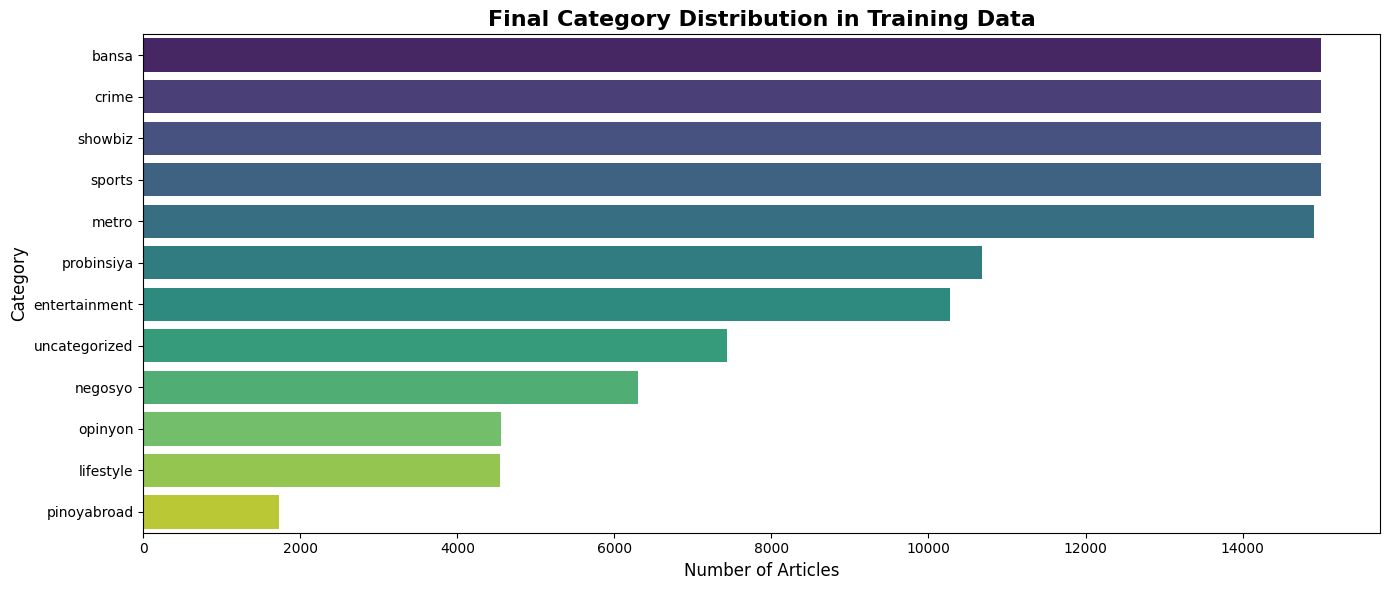

In [ ]:
"""
Main content:
Filters out low-sample categories, excludes generic 'news'/'balita' from the final training set,
applies a per-category upper bound sampling (MAX_SAMPLES_PER_CATEGORY), computes final counts,
and renders a barplot of the resulting distribution.
"""
#Count category frequencies
category_counts = train_df['category'].value_counts()
print("Category distribution (top 20):")
print(category_counts.head(20))
print()
#Filter categories with minimum samples
MIN_SAMPLES = 100
valid_categories = category_counts[category_counts >= MIN_SAMPLES].index.tolist()

#Remove balita and news
categories_to_remove = ['balita', 'news']
for cat in categories_to_remove:
    if cat in valid_categories:
        valid_categories.remove(cat)
        print(f"✗ Removed '{cat}' from training")

print(f"\nRemaining categories: {len(valid_categories)}")
print(f"Categories: {sorted(valid_categories)}\n")

#Filter datasets
train_df = train_df[train_df['category'].isin(valid_categories)].reset_index(drop=True)
val_df = val_df[val_df['category'].isin(valid_categories)].reset_index(drop=True)
test_df = test_df[test_df['category'].isin(valid_categories)].reset_index(drop=True)

MAX_SAMPLES_PER_CATEGORY = 15000

train_df = train_df.groupby('category', group_keys=False).apply(
    lambda x: x.sample(min(len(x), MAX_SAMPLES_PER_CATEGORY), random_state=42)
).reset_index(drop=True)

print("Samples per category after balancing:")
balanced_counts = train_df['category'].value_counts().sort_index()
for cat, count in balanced_counts.items():
    print(f"  {cat:20s}: {count:,} samples")

plt.figure(figsize=(14, 6))
final_counts = train_df['category'].value_counts()
sns.barplot(x=final_counts.values, y=final_counts.index, palette="viridis")
plt.title('Final Category Distribution in Training Data', fontsize=16, fontweight='bold')
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
"""
Main functions:
- extract_top_words(df, category, n_words=20):
    Concatenates 'combined_text' strings for the given category into one large text,
    tokenizes with a regex for word characters, filters short tokens, stopwords and digits,
    computes word counts using collections.Counter, and returns the n most common words
    along with frequencies as a list of (word, count) tuples.
"""


def extract_top_words(df, category, n_words=20):
    category_texts = df[df['category'] == category]['combined_text']

    all_text = ' '.join(category_texts.values)
    
    words = re.findall(r'\b\w+\b', all_text.lower())
    
    words = [
        w for w in words 
        if len(w) > 2 
        and w not in combined_stopwords
        and not w.isdigit()
    ]
    word_counts = Counter(words)
    
    return word_counts.most_common(n_words)

print("Top words based on TF-IDF results...\n")
top_categories = train_df['category'].value_counts().head(5).index

for cat in top_categories:
    count = len(train_df[train_df['category'] == cat])
    print(f"\n{'=' * 70}")
    print(f"CATEGORY: {cat.upper()} ({count:,} articles)")
    print(f"{'=' * 70}")
    
    top_words = extract_top_words(train_df, cat, n_words=20)
    
    print("\nMost frequent words:")
    for i, (word, freq) in enumerate(top_words, 1):
        print(f"  {i:2d}. {word:20s} ({freq:,} occurrences)")


Top words based on TF-IDF results...


CATEGORY: BANSA (15,000 articles)

Most frequent words:
   1. naman                (11,075 occurrences)
   2. kay                  (10,369 occurrences)
   3. ayon                 (10,165 occurrences)
   4. covid                (9,332 occurrences)
   5. duterte              (8,725 occurrences)
   6. rin                  (8,698 occurrences)
   7. nang                 (7,603 occurrences)
   8. sinabi               (7,336 occurrences)
   9. bansa                (7,280 occurrences)
  10. noong                (6,717 occurrences)
  11. umano                (5,965 occurrences)
  12. lang                 (5,714 occurrences)
  13. city                 (5,607 occurrences)
  14. pag                  (5,440 occurrences)
  15. manila               (5,370 occurrences)
  16. health               (4,941 occurrences)
  17. national             (4,931 occurrences)
  18. department           (4,860 occurrences)
  19. pang                 (4,848 occurrences)
  20. dag

In [ ]:
"""
Main content:
- label2id: dict[str, int] — mapping from category name to integer label.
- id2label: dict[int, str] — inverse mapping written to label_map.json.
- No separate functions defined in this block; mapping is created inline.
"""

#Create label mappings
categories = sorted(train_df['category'].unique())
label2id = {label: idx for idx, label in enumerate(categories)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Total categories for training: {len(categories)}")
print("\nLabel mapping (first 10):")
for i, (label, idx) in enumerate(list(label2id.items())[:10]):
    print(f"  {idx:2d} -> {label}")
print("  ...")
print()
#Add numeric labels to dataframes
train_df['label'] = train_df['category'].map(label2id)
val_df['label'] = val_df['category'].map(label2id)
test_df['label'] = test_df['category'].map(label2id)


Total categories for training: 12

Label mapping (first 10):
   0 -> bansa
   1 -> crime
   2 -> entertainment
   3 -> lifestyle
   4 -> metro
   5 -> negosyo
   6 -> opinyon
   7 -> pinoyabroad
   8 -> probinsiya
   9 -> showbiz
  ...



In [ ]:
"""
Main content:
- MODEL_NAME, MAX_LENGTH constants.
- tokenizer: XLMRobertaTokenizer instance.
- model: XLMRobertaForSequenceClassification loaded with num_labels and label maps.
- device: Torch device selection.
- No standalone functions in this block.
"""


MODEL_NAME = 'xlm-roberta-base'
MAX_LENGTH = 256  # CHANGED: Reduced from 256 to save memory

tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

model = XLMRobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(categories),
    id2label=id2label,
    label2id=label2id
)

model.classifier.dropout = torch.nn.Dropout(0.3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

sample_text = train_df.iloc[0]['combined_text'][:200]
print("Testing tokenization with sample text:")
print(f"Original: {sample_text}...")
tokens = tokenizer(sample_text, truncation=True, max_length=MAX_LENGTH, padding='max_length')
print(f"Tokenized length: {len(tokens['input_ids'])} tokens")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Testing tokenization with sample text:
Original: Bato: Ano kung mawalan ng trabaho ang 11K worker ng ABS-CBN kumpara sa Filipino nation na sinamantala? Inihayag ni Senador Ronald “Bato” dela Rosa nitong Martes na mas mahalaga ang kapakanan ng bansa ...
Tokenized length: 256 tokens


In [ ]:
"""
Main classes/methods:
- class NewsDataset(Dataset):
    - __init__(self, texts, labels, tokenizer, max_length):
        Stores input texts, labels, tokenizer, and max_length. Prepares the dataset for indexing.

    - __len__(self):
        Returns the number of examples in the dataset.

    - __getitem__(self, idx):
        For a given index, converts the text to string, retrieves the label, tokenizes using the provided
        tokenizer with truncation and padding to max_length returning PyTorch tensors, and returns a dict:
        {
          'input_ids': Tensor shape (max_length,),
          'attention_mask': Tensor shape (max_length,),
          'labels': long tensor scalar
        }
"""


class NewsDataset(Dataset):
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
#Create datasets
train_dataset = NewsDataset(
    train_df['combined_text'].values,
    train_df['label'].values,
    tokenizer,
    MAX_LENGTH
)

val_dataset = NewsDataset(
    val_df['combined_text'].values,
    val_df['label'].values,
    tokenizer,
    MAX_LENGTH
)

test_dataset = NewsDataset(
    test_df['combined_text'].values,
    test_df['label'].values,
    tokenizer,
    MAX_LENGTH
)

In [ ]:
"""
Wraps NewsDataset instances into PyTorch DataLoaders for training, validation, and test.

Main content:
- BATCH_SIZE constant.
- train_loader, val_loader, test_loader: DataLoader objects created inline.
- No standalone functions in this block.
"""

BATCH_SIZE = 8 #Adjust based on GPU memory

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
"""
Main content:
- optimizer = AdamW
- scheduler = get_linear_schedule_with_warmup
- class_weights: computed via sklearn.utils.class_weight.compute_class_weight and converted to torch tensor.
- loss_fct: torch.nn.CrossEntropyLoss instantiated with class_weights.
"""

EPOCHS = 5  # CHANGED: Increased from 3 (model was still learning)
LEARNING_RATE = 1e-5  # CHANGED: Reduced from 2e-5 for finer tuning
WARMUP_STEPS = 1000  # CHANGED: Increased from 500
GRADIENT_ACCUMULATION_STEPS = 2  # NEW: Simulate batch_size=16 with less memory

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
print("✓ Optimizer (AdamW) initialized")

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights[label2id['crime']] *= 0.6
class_weights[label2id['lifestyle']] *= 0.7
class_weights[label2id['entertainment']] *= 0.8

for i, (label, weight) in enumerate(sorted(zip(train_df['category'].unique(), class_weights))):
    if i < 5 or weight > 2.0:  # Show first 5 and any high weights
        print(f"  {label:20s}: {weight:.3f}")
if len(class_weights) > 5:
    print(f"  ... ({len(class_weights) - 5} more categories)")

✓ Optimizer (AdamW) initialized
  bansa               : 0.669
  crime               : 0.401
  entertainment       : 0.781
  lifestyle           : 1.548
  metro               : 0.673
  opinyon             : 2.201
  pinoyabroad         : 5.795
  ... (7 more categories)


In [ ]:
"""
Main content:
- EPOCHS, history dict, best_val_acc tracking.
- For-loop over epochs that calls train_epoch and evaluate, handles saving the best model state.
"""


loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)

def train_epoch(model, data_loader, optimizer, scheduler, device, epoch, loss_function):
    """Train for one epoch (with keep-alive output)"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch}')
    
    optimizer.zero_grad()  # Zero gradients at start
    
    for step, batch in enumerate(progress_bar):
        #Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        #Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits

        loss = loss_function(logits, labels)

        loss = loss / GRADIENT_ACCUMULATION_STEPS

        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        #Backward pass
        loss.backward()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        #Update metrics
        total_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS

        progress_bar.set_postfix({
            'loss': f'{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}',
            'acc': f'{correct_predictions/total_predictions:.4f}'
        })

    if (step + 1) % GRADIENT_ACCUMULATION_STEPS != 0:
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / len(data_loader)
    avg_acc = correct_predictions / total_predictions
    
    return avg_loss, avg_acc

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            predictions = torch.argmax(logits, dim=1)
            
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            total_loss += loss.item()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    avg_acc = correct_predictions / total_predictions
    
    return avg_loss, avg_acc, all_predictions, all_labels
    
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"Starting training for {EPOCHS} epochs...\n")

best_val_acc = 0
for epoch in range(1, EPOCHS + 1):
    print(f"\n{'=' * 70}")
    print(f"EPOCH {epoch}/{EPOCHS}")
    print(f"{'=' * 70}")
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device, epoch, loss_fct)
    print(f"\nTraining   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"✓ New best model saved! (Validation Accuracy: {val_acc:.4f})")


Starting training for 5 epochs...


EPOCH 1/5


Epoch 1:   0%|          | 0/15056 [00:00<?, ?it/s]


Training   - Loss: 0.9067, Accuracy: 0.6850


Evaluating:   0%|          | 0/4288 [00:00<?, ?it/s]

Validation - Loss: 0.7068, Accuracy: 0.7601
✓ New best model saved! (Validation Accuracy: 0.7601)

EPOCH 2/5


Epoch 2:   0%|          | 0/15056 [00:00<?, ?it/s]


Training   - Loss: 0.5444, Accuracy: 0.8126


Evaluating:   0%|          | 0/4288 [00:00<?, ?it/s]

Validation - Loss: 0.5957, Accuracy: 0.7994
✓ New best model saved! (Validation Accuracy: 0.7994)

EPOCH 3/5


Epoch 3:   0%|          | 0/15056 [00:00<?, ?it/s]


Training   - Loss: 0.4590, Accuracy: 0.8397


Evaluating:   0%|          | 0/4288 [00:00<?, ?it/s]

Validation - Loss: 0.6638, Accuracy: 0.7697

EPOCH 4/5


Epoch 4:   0%|          | 0/15056 [00:00<?, ?it/s]


Training   - Loss: 0.3942, Accuracy: 0.8612


Evaluating:   0%|          | 0/4288 [00:00<?, ?it/s]

Validation - Loss: 0.6090, Accuracy: 0.7921

EPOCH 5/5


Epoch 5:   0%|          | 0/15056 [00:00<?, ?it/s]


Training   - Loss: 0.3417, Accuracy: 0.8792


Evaluating:   0%|          | 0/4288 [00:00<?, ?it/s]

Validation - Loss: 0.5682, Accuracy: 0.8141
✓ New best model saved! (Validation Accuracy: 0.8141)


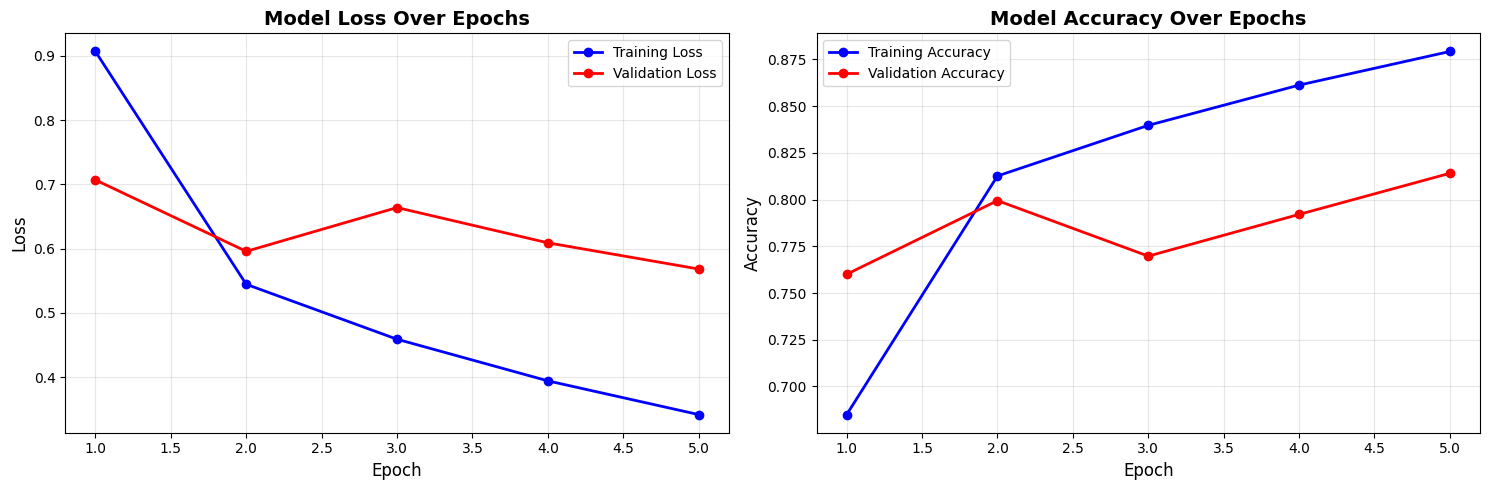

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, EPOCHS + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 'r-o', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc, test_predictions, test_labels = evaluate(model, test_loader, device)

Evaluating:   0%|          | 0/4279 [00:00<?, ?it/s]

In [ ]:
"""
Main content:
- model.load_state_dict(torch.load('best_model.pt')) called inline.
- test_loss, test_acc, test_predictions, test_labels obtained by calling evaluate().
- No standalone functions.
"""

test_pred_categories = [id2label[pred] for pred in test_predictions]
test_true_categories = [id2label[label] for label in test_labels]

report = classification_report(
    test_true_categories, 
    test_pred_categories,
    digits=4,
    zero_division=0
)
print(report)

with open('classification_report.txt', 'w') as f:
    f.write(report)

               precision    recall  f1-score   support

        bansa     0.9542    0.7123    0.8157     11826
        crime     0.7396    0.7830    0.7607      2046
entertainment     0.6716    0.8813    0.7623      1297
    lifestyle     0.4794    0.7517    0.5854       572
        metro     0.5381    0.8281    0.6524      1891
      negosyo     0.5506    0.9060    0.6849       787
      opinyon     0.8084    0.8969    0.8504       621
  pinoyabroad     0.3555    0.9350    0.5152       200
   probinsiya     0.6430    0.8809    0.7434      1276
      showbiz     0.9665    0.8315    0.8939      8149
       sports     0.9508    0.9791    0.9647      4637
uncategorized     0.4320    0.7834    0.5569       928

     accuracy                         0.8118     34230
    macro avg     0.6741    0.8474    0.7322     34230
 weighted avg     0.8610    0.8118    0.8225     34230



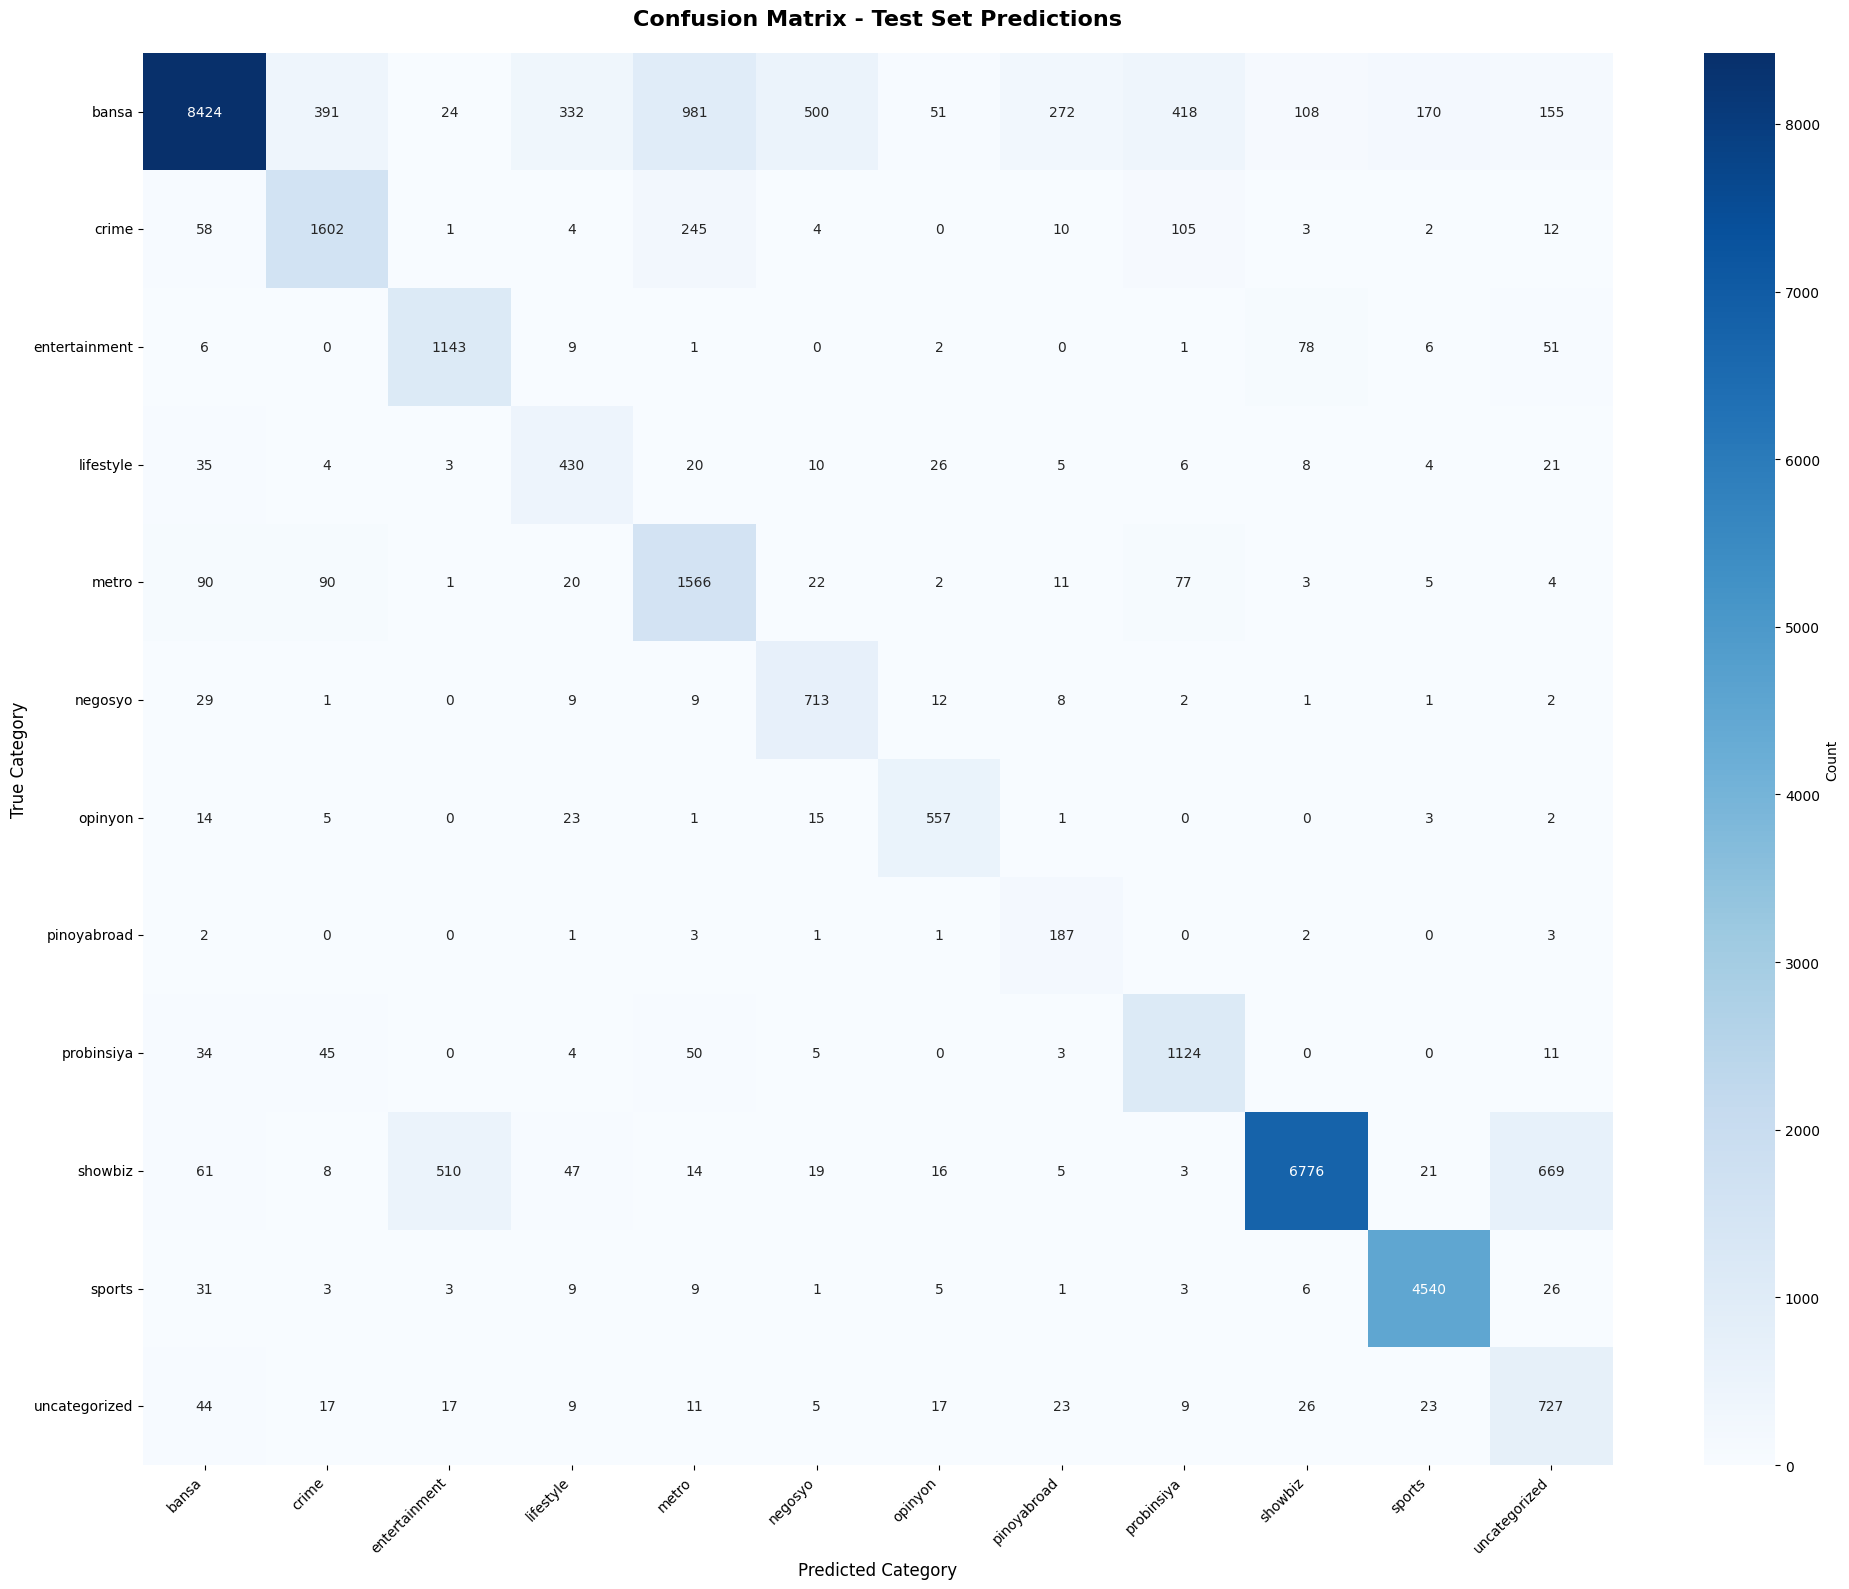

In [ ]:
"""
Main content:
- report = classification_report(...)
"""

cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(20, 16))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=[id2label[i] for i in range(len(categories))],
    yticklabels=[id2label[i] for i in range(len(categories))],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set Predictions', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
"""
Randomly selects a few examples from the test set and runs the model to show predicted label and
confidence alongside the true label for qualitative inspection.
"""


sample_indices = np.random.choice(len(test_df), 5, replace=False)

model.eval()
for idx in sample_indices:
    text = test_df.iloc[idx]['combined_text']
    true_label = test_df.iloc[idx]['category']
    
    # Tokenize and predict
    inputs = tokenizer(
        text,
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        return_tensors='pt'
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
        probs = torch.softmax(outputs.logits, dim=1)[0]
        confidence = probs[prediction].item()
    
    predicted_label = id2label[prediction]

In [20]:
print(f"\n{'PROJECT SUMMARY':^70}")
print(f"Dataset: BalitaNLP Filipino News Classification")
print(f"Model: XLM-RoBERTa Base (Multilingual)")
print(f"\nData Statistics:")
print(f"  • Original categories: 81")
print(f"  • After preprocessing: {len(categories)}")
print(f"  • Training samples: {len(train_df):,}")
print(f"  • Validation samples: {len(val_df):,}")
print(f"  • Test samples: {len(test_df):,}")
print(f"\nTraining Configuration:")
print(f"  • Epochs: {EPOCHS}")
print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Learning rate: {LEARNING_RATE}")
print(f"  • Max sequence length: {MAX_LENGTH}")
print(f"\nFinal Results:")
print(f"  • Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  • Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"\nSaved Files:")
print(f"  • best_model.pt - Trained model weights")
print(f"  • training_history.png - Loss and accuracy plots")
print(f"  • confusion_matrix.png - Confusion matrix visualization")
print(f"  • classification_report.txt - Detailed per-category metrics")


                           PROJECT SUMMARY                            
Dataset: BalitaNLP Filipino News Classification
Model: XLM-RoBERTa Base (Multilingual)

Data Statistics:
  • Original categories: 81
  • After preprocessing: 12
  • Training samples: 120,442
  • Validation samples: 34,300
  • Test samples: 34,230

Training Configuration:
  • Epochs: 5
  • Batch size: 8
  • Learning rate: 1e-05
  • Max sequence length: 256

Final Results:
  • Best Validation Accuracy: 0.8141 (81.41%)
  • Test Accuracy: 0.8118 (81.18%)

Saved Files:
  • best_model.pt - Trained model weights
  • training_history.png - Loss and accuracy plots
  • confusion_matrix.png - Confusion matrix visualization
  • classification_report.txt - Detailed per-category metrics


In [21]:
import os

os.makedirs("/kaggle/working/final_model", exist_ok=True)
model.save_pretrained("/kaggle/working/final_model")
tokenizer.save_pretrained("/kaggle/working/final_model")

with open("/kaggle/working/final_model/label_map.json", "w", encoding="utf-8") as f:
    json.dump(id2label, f, indent=4, ensure_ascii=False)

config = {
    "model_name": MODEL_NAME,  # Changed from model_name to MODEL_NAME
    "num_labels": len(label2id),
    "max_length": MAX_LENGTH,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "test_accuracy": float(test_acc)  # Convert to float for JSON serialization
}

with open("/kaggle/working/final_model/training_config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, indent=4)